K-Means

In [18]:
%load_ext google.cloud.bigquery
%matplotlib inline
from google.cloud import bigquery
client = bigquery.Client()
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import random
from sklearn.cluster import KMeans
import matplotlib.cm as cm
%run silhouette_plotter.py
%run parse.py
from mpl_toolkits.mplot3d import Axes3D

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
sql = '''
SELECT *  FROM `eth-tokens.test.clean_avg_1MM_with_balances_tokens`
'''

df = client.query(sql).to_dataframe()

In [3]:
#remove address (string) from analysis
data = df.iloc[:,1:]

In [4]:
#number of PCA features is full reconstruction, for now
# num_features = data.shape[1]
num_clusters = 4
num_features = 15

In [5]:
scale = StandardScaler()
pca =PCA(n_components=num_features)
cl = KMeans(num_clusters)
#build pipeline
pipe = Pipeline([('scale', scale ),
                 ('PCA', pca)])

results = pipe.fit_transform(data)




In [ ]:
#percent of variance explained by each component

plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [ ]:
#scoring metric?
from sklearn.metrics import calinski_harabaz_score as ch_score
clusters = [3,5,8,10,15,20,25,30,35,40,45,60,80,100,150,200]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(results)
    score = ch_score(results, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

In [ ]:
#elbow plot
plt.plot(clusters,inertias)
plt.title('Elbow plot')
plt.ylabel('within cluster sum of squares')

In [6]:
#optimal number of clusters is around 40
cl = KMeans(40)
cl.fit(results)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=40, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [ ]:
#outlier removal


def remove_outliers(results, cl, threshold):
    '''
    returns subset of results, and associated labels as a tuple
    takes results and a fit KMeans cluster object'''
    
    new_labels = []
    new_results = []
    
    
    #code for deciding what clusters to keep
    for i, center in enumerate(cl.cluster_centers_):
        within_cluster_results = results[cl.labels_==i]
        centroid = cl.cluster_centers_[i]
        #calc std vectors
        stdev = np.std(within_cluster_results, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_results), axis=1) < threshold*np.linalg.norm(stdev)
        new_results.append(within_cluster_results[keep])
        #add labels?
        new_labels.extend([i for j in range(len(within_cluster_results[keep]))])
    return np.vstack(new_results), np.array(new_labels)


In [ ]:
thresholds = np.linspace(.3,3, 20)

test = [remove_outliers(results, cl,t) for t in thresholds]

scores= []
for (res, labels) in test:
    
    score = ch_score(res, labels)
    scores.append(score)

In [ ]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [ ]:
#empirical best threshold 1 stdev
newresults, labels = remove_outliers(results, cl,1)

In [ ]:
%run silhouette_plotter.py
X=results
range_n_clusters = [20]
if len(newresults) <20000:
    silhouette_plotter(X, range_n_clusters)

In [13]:
#subset results for tsne
max_size = 20000
subset_results = []
lbls = []
for c in np.unique(cl.labels_):
    mask = (cl.labels_==c)
    c_size = np.sum(mask)
    if c_size < max_size:
        lbls.extend(list(cl.labels_[cl.labels_==c]))
        subset_results.append(results[mask])
lbls=np.array(lbls)
subset_results=np.vstack(subset_results)

In [14]:
import time
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(subset_results)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 67600 samples in 0.101s...
[t-SNE] Computed neighbors for 67600 samples in 8.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 67600
[t-SNE] Computed conditional probabilities for sample 2000 / 67600
[t-SNE] Computed conditional probabilities for sample 3000 / 67600
[t-SNE] Computed conditional probabilities for sample 4000 / 67600
[t-SNE] Computed conditional probabilities for sample 5000 / 67600
[t-SNE] Computed conditional probabilities for sample 6000 / 67600
[t-SNE] Computed conditional probabilities for sample 7000 / 67600
[t-SNE] Computed conditional probabilities for sample 8000 / 67600
[t-SNE] Computed conditional probabilities for sample 9000 / 67600
[t-SNE] Computed conditional probabilities for sample 10000 / 67600
[t-SNE] Computed conditional probabilities for sample 11000 / 67600
[t-SNE] Computed conditional probabilities for sample 12000 / 67600
[t-SNE] Computed conditional probabilities for sa

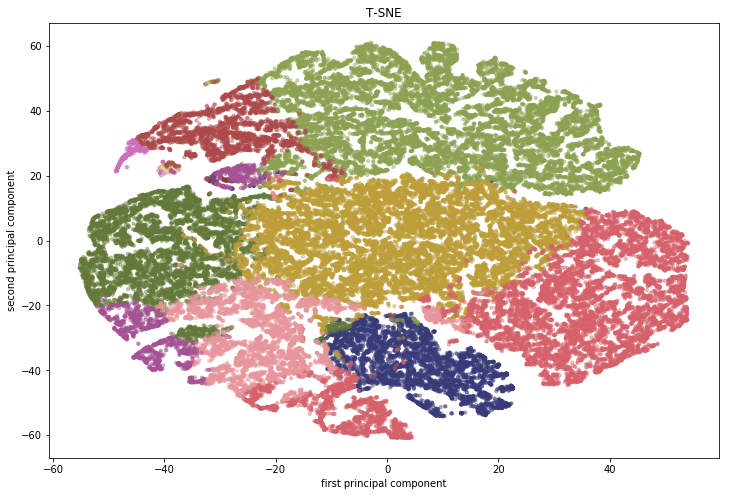

In [15]:
plt.figure(figsize=(12,8))

plt.scatter(tsne_results[:,0], tsne_results[:,1], s=10,c=lbls,cmap='tab20b', alpha=.4)


# leg = plt.legend()




# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

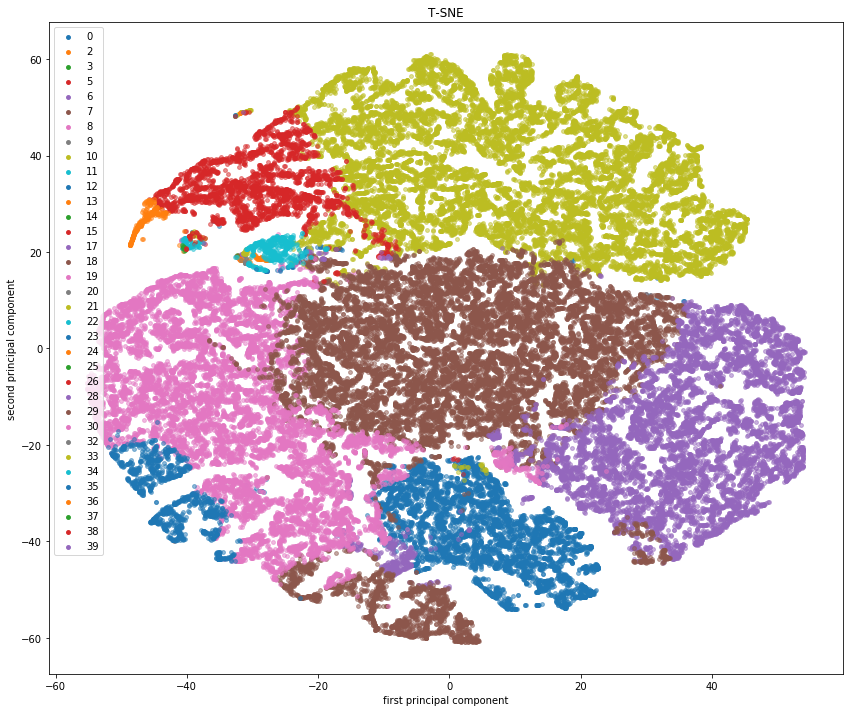

In [16]:
plt.figure(figsize=(12,10))
for c in np.unique(lbls):
    mask = lbls==c
    if np.sum(mask) <0:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], s=15,alpha=.5,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.tight_layout()

In [ ]:

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for c in np.unique(cl.labels_):
#     mask = cl.labels_==c
#     if np.sum(mask) <50:
#         lbl = '_nolegend_'
#     else:
#         lbl = c
#     ax.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], tsne_results[mask][:,2], s=10, alpha=.01,label=lbl)
# leg = plt.legend()
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)
# ax.set_xlabel('first principal component')
# ax.set_ylabel('second principal component')
# ax.set_zlabel('third principal component')
# ax.view_init(elev=30, azim=0)
# plt.show()


In [ ]:

plt.scatter(newresults[:,0],newresults[:,1],c=labels)
# plt.xlim(0,10)
# plt.ylim(-10,10)

In [ ]:
plt.scatter(results[:,0],results[:,1],c=cl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)

In [ ]:
# #recluster after changes
# cl = KMeans(20).fit(results)
newcl = KMeans(40).fit(newresults)

In [ ]:
# %matplotlib widget
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

In [ ]:

# plt.scatter(newresults[:,0],newresults[:,1],c=newcl.labels_)
# plt.xlim(-10,100)
# plt.ylim(-15,10)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(results[:,0],results[:,1],results[:,2],c=cl.labels_)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-15,10)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)

In [ ]:
# %matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(newresults[:,0],newresults[:,1],newresults[:,2],c=newcl.labels_)
# ax.set_xlim3d(-1,1)
# ax.set_ylim3d(-3,3)
# ax.view_init(elev=-0, azim=90)
# for ii in range(10,360,10):
#     ax.view_init(elev=10, azim=ii)
#     fig.savefig("movie/movie{}.png".format(ii))

In [ ]:
c = cl.cluster_centers_
#transform back to real numbers
centroids = scale.inverse_transform(pca.inverse_transform(c))
df_summary = pd.DataFrame(centroids, columns = data.columns)

In [ ]:
cluster_sizes = pd.Series(cl.labels_).value_counts()
df_summary['cluster_size'] = cluster_sizes


In [ ]:
df_summary.sort_values('cluster_size', ascending=False, axis=0, inplace=True)
df_summary

In [ ]:
import seaborn as sns
sns.heatmap(df_summary.corr())

In [ ]:
arr = df_summary.values

In [ ]:
arr.shape

In [ ]:
sns.heatmap(np.corrcoef(arr, rowvar=True))

In [ ]:
# for col in df_summary.columns:
#     df_summary[col].hist()
#     plt.title(col)
#     plt.show()

In [ ]:
p = PCA(n_components=3)

In [ ]:
vectors = p.fit_transform(arr[:8,:])

In [ ]:

xs = vectors[:,0]
ys = vectors[:,1]
zs = vectors[:,2]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
    ax.plot([0,x], [0,y],[0,z], label=i)
plt.legend()

In [20]:
sql = '''
SELECT es.label,es.category, a.*  FROM `eth-tokens.test.clean_avg_1MM_with_balances_tokens` a
INNER JOIN `eth-tokens.alldata.etherscan_labelcloud` es
ON a.address = es.address
WHERE es.label IS NOT NULL

'''

dflabel = client.query(sql).to_dataframe()

In [21]:
dflabel.shape

(182, 28)

In [22]:
lbls = []
for i, row in dflabel.iterrows():
    lbls.append(list(df['address'].values).index(row['address']))

In [23]:
dflabel['cluster'] = [cl.labels_[i] for i in lbls]

In [24]:
dflabel

,label,category,address,outgoing_txns,incoming_txns,total_eth_sent,avg_eth_sent,total_usd_sent,avg_usd_sent,total_eth_recd,...,monthly_usd_recd,contracts_created,contract_txns_sent,incoming_avg_time_btwn_txns,incoming_std_time_btwn_txns,outgoing_avg_time_btwn_txns,outgoing_std_time_btwn_txns,num_tokens_used,eth_balance,cluster
0,Bgogo_1,Exchange,0x7a10ec7d68a048bdae36a70e93532d31423170fa,4634,42,55512.9469664,11.979487908,1.193449e+07,2.575420e+03,58124.066213484,...,4.162975e+06,0,0,1.383690e+05,1.409740e+05,1.257425e+03,4.127817e+03,5,486.335359084,1
1,Bgogo_2,Exchange,0xce1bf8e51f8b39e51c6184e059786d1c0eaf360f,36,5043,57900,1608.333333333,1.248853e+07,3.469036e+05,61671.7841197,...,4.418291e+06,0,0,9.234072e+02,1.880744e+04,1.373183e+05,1.435795e+05,16,4361.036312862,1
2,Fake_Phishing2168,Phish/Hack,0xe55996c55e188fbcf95ed6ca96fa933171c05fa0,39,3,4.49814198,0.115336974,9.625667e+02,2.468120e+01,6.29532325,...,6.588822e+02,0,0,8.628800e+04,4.121018e+03,1.129844e+05,2.444354e+05,1,1.77895327,1
3,Fake_Phishing2172,Phish/Hack,0x0cd4ea9b68ced287fc25923b071c0b1a0a14e9c6,3,6,3,1,1.254080e+03,4.180267e+02,12.04453369,...,1.262294e+03,0,0,4.478660e+04,3.980184e+04,1.939075e+05,2.740272e+05,1,9.04220269,1
4,Fake_Phishing1822,Phish/Hack,0xce9e24dffdb3dc08efe33ad3db858576c3f27d5d,5,15,0.152271677,0.030454335,7.338025e+01,1.467605e+01,13.149842315,...,1.256999e+03,0,0,1.748954e+05,2.330848e+05,5.331485e+05,3.699470e+05,2,12.990745638,1
5,Fake_Phishing1816,Phish/Hack,0xebfce0f5135c0bd67f9fa5b1ae1366a566f659ff,5,15,0.10558692,0.021117384,4.933489e+01,9.866978e+00,10.58902434,...,9.773935e+02,0,0,1.039599e+05,1.948596e+05,2.899012e+05,4.372348e+05,2,10.47367242,1
6,Rate3_Wallet2,ICO Wallets,0x841991ffe0dafd619bc517d82ee4700c37136140,7,5,5040,720,1.877741e+06,2.682487e+05,9684.7308,...,8.097912e+05,0,0,1.017963e+06,1.390813e+06,7.171660e+05,1.001970e+06,3,4644.727651874,1
7,Fake_Phishing1978,Phish/Hack,0x0fa3202e9f247f9349352c4296d2bbd6c7fa11b4,190,91,0.6293,0.003312105,2.256344e+02,1.187549e+00,2.543249492,...,1.815959e+02,0,0,4.102533e+04,2.040587e+05,4.965298e+04,4.389640e+05,35,1.73592354,1
8,Bitmax_1,Exchange,0x03bdf69b1322d623836afbd27679a1c0afa067e9,1061,1081,3348.282084541,3.155779533,7.798949e+05,7.350565e+02,6077.344511858,...,2.748006e+05,0,0,9.625878e+03,6.593208e+04,9.759738e+03,5.313994e+04,13,3871.119196898,1
9,TheOcean,0x Ecosystem,0x7219612be7036d1bfa933e16ca1246008f38c5fe,5,7,0.005,0.001,2.393750e+00,4.787500e-01,59.16455627,...,5.702990e+03,0,0,2.607233e+04,4.326595e+04,6.284165e+05,1.136622e+06,14,13.088429247,1


In [25]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label','category']])
    print('\n\n\n')

cluster 0
labelled points: 7
total points: 5514
                 label    category
130    Fake_Phishing37  Phish/Hack
146         Suprnova_2      Mining
148          Ethpool_2      Mining
149          AlphaPool      Mining
175  JordiBaylina(WHG)   White Hat
179       Poloniex_REP    Exchange
180       Poloniex_REP    Poloniex




cluster 1
labelled points: 30
total points: 29383
                  label      category
0               Bgogo_1      Exchange
1               Bgogo_2      Exchange
2     Fake_Phishing2168    Phish/Hack
3     Fake_Phishing2172    Phish/Hack
4     Fake_Phishing1822    Phish/Hack
5     Fake_Phishing1816    Phish/Hack
6         Rate3_Wallet2   ICO Wallets
7     Fake_Phishing1978    Phish/Hack
8              Bitmax_1      Exchange
9              TheOcean  0x Ecosystem
10             TheOcean           Dex
11             Bitmax_2      Exchange
12    Fake_Phishing1817    Phish/Hack
14    Fake_Phishing1952    Phish/Hack
15        Coinrail_Hack         Heist
16        

centralization of ownership

In [26]:
total_eth = {}
total_addresses = {}

for clust in range(cl.n_clusters):
    mask = cl.labels_==clust
    eth = np.sum(df[mask]['eth_balance'])
    size = np.sum(cl.labels_==clust)
    total_eth[clust] = eth
    total_addresses[clust] = size

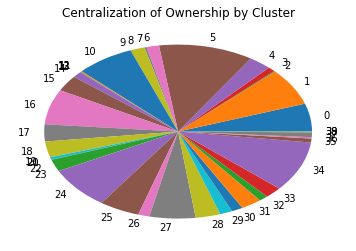

In [27]:
plt.pie(total_eth.values(), labels=total_eth.keys())
plt.title('Centralization of Ownership by Cluster')
plt.show()

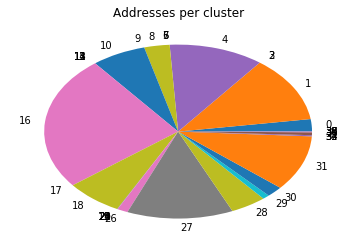

In [28]:
plt.pie(total_addresses.values(), labels=total_addresses.keys())
plt.title('Addresses per cluster')
plt.show()

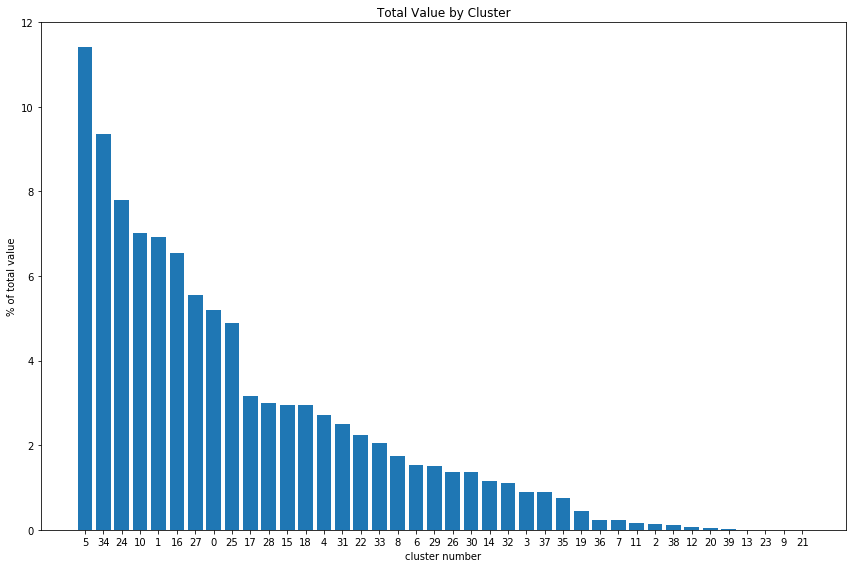

In [29]:

names = np.array(list(total_eth.keys()))
values = np.array(list(total_eth.values()))
indices = np.argsort(values)

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_eth)),values/sum(values)*100,tick_label=names)
plt.title('Total Value by Cluster')
plt.xlabel('cluster number')
plt.ylabel('% of total value')
# plt.yscale('log')
plt.tight_layout()
plt.show()




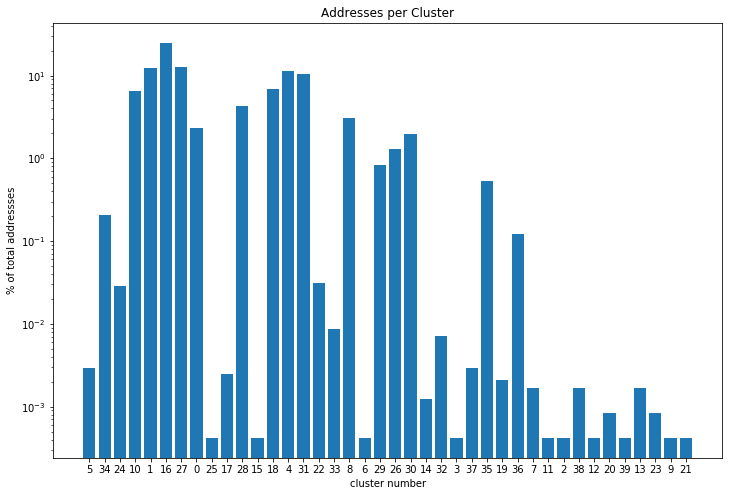

In [30]:

names = np.array(list(total_addresses.keys()))
values = np.array(list(total_addresses.values()))

names = names[indices][::-1]
values = values[indices][::-1]
                  
#tick_label does the some work as plt.xticks()
plt.figure(figsize=(12,8))
plt.bar(range(len(total_addresses)),values/sum(values)*100,tick_label=names)
plt.title('Addresses per Cluster')
plt.yscale('log')
plt.xlabel('cluster number')
plt.ylabel('% of total addressses')
plt.show()

cluster 0


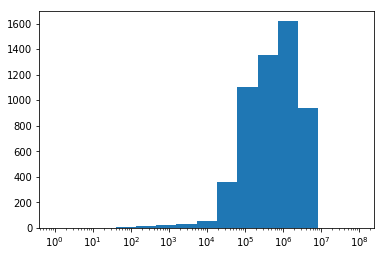

cluster 1


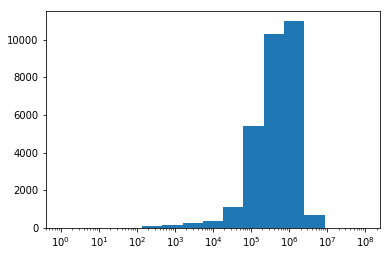

cluster 2


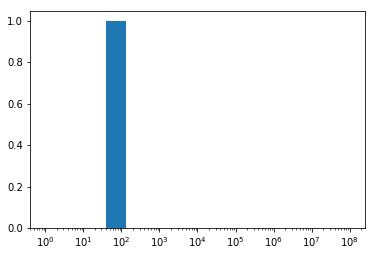

cluster 3


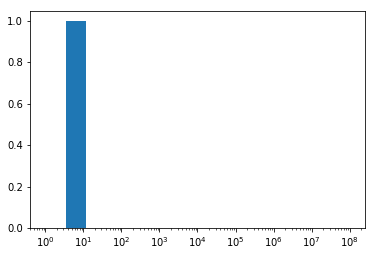

cluster 4


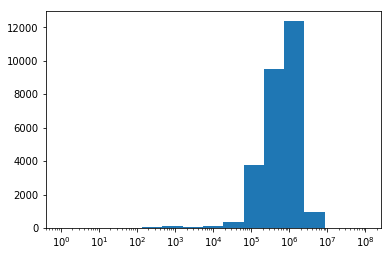

cluster 5


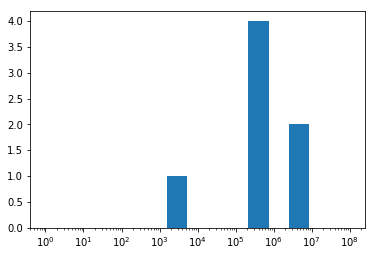

cluster 6


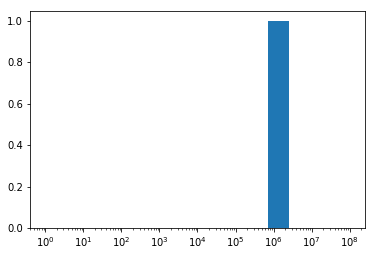

cluster 7


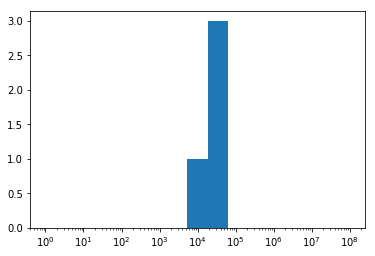

cluster 8


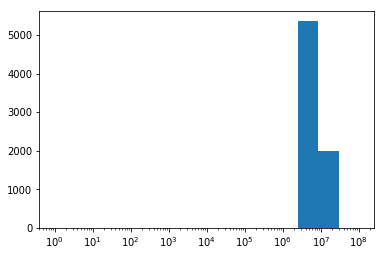

cluster 9


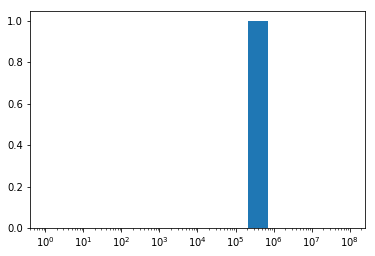

cluster 10


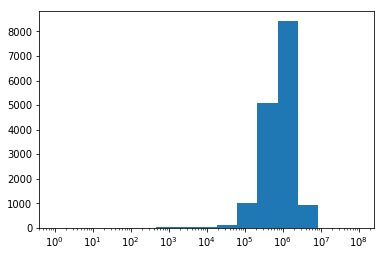

cluster 11


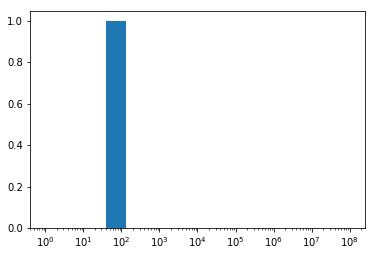

cluster 12


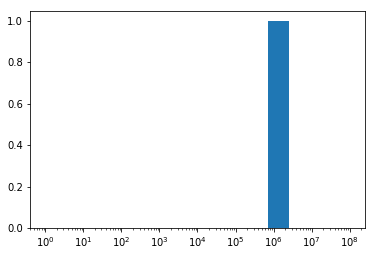

cluster 13


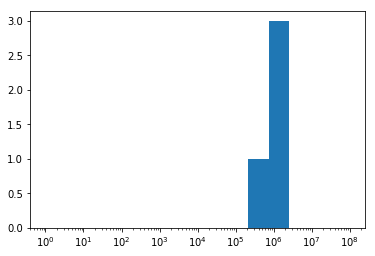

cluster 14


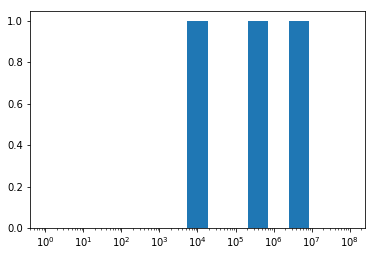

cluster 15


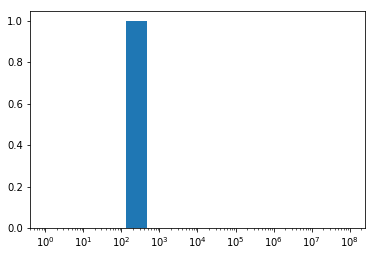

cluster 16


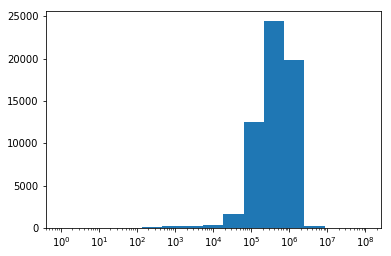

cluster 17


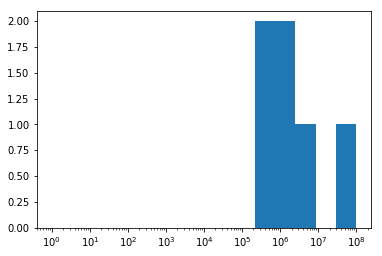

cluster 18


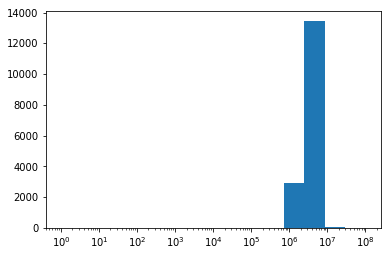

cluster 19


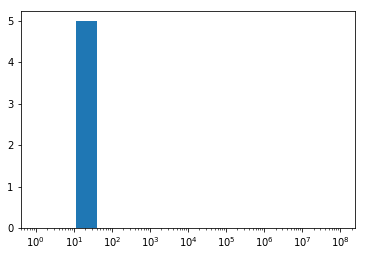

cluster 20


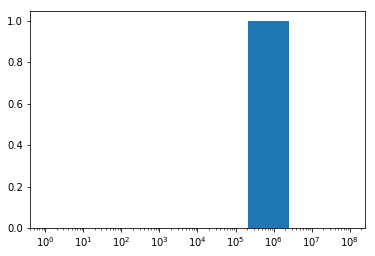

cluster 21


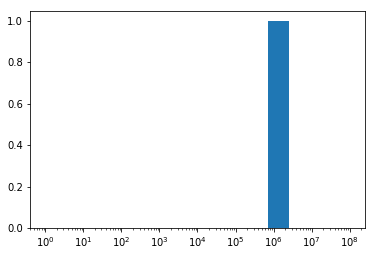

cluster 22


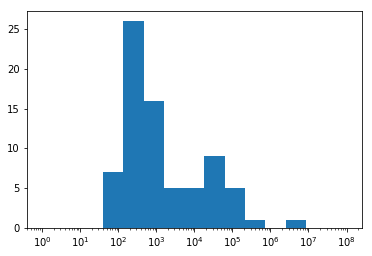

cluster 23


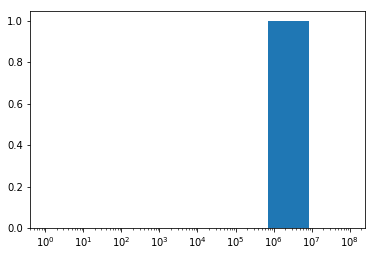

cluster 24


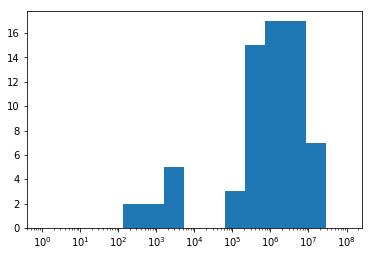

cluster 25


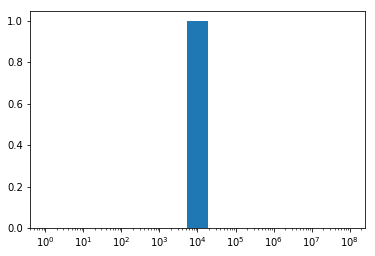

cluster 26


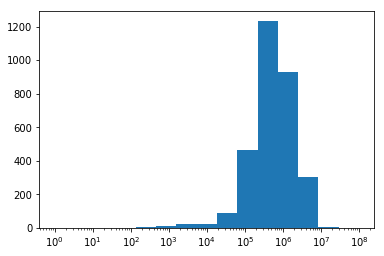

cluster 27


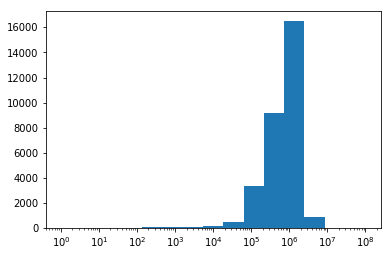

cluster 28


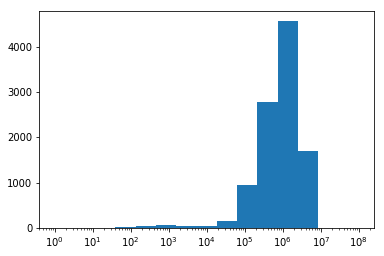

cluster 29


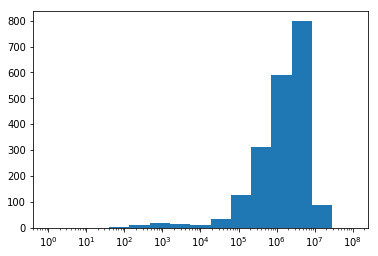

cluster 30


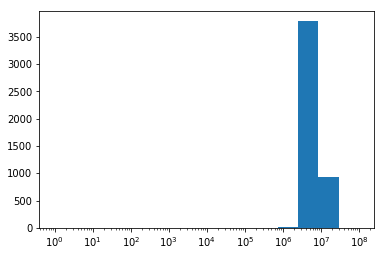

cluster 31


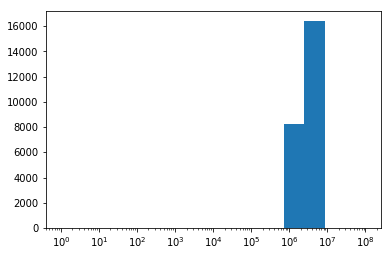

cluster 32


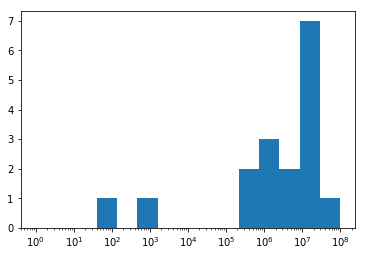

cluster 33


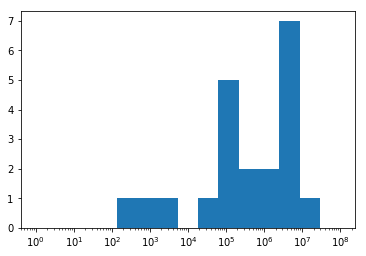

cluster 34


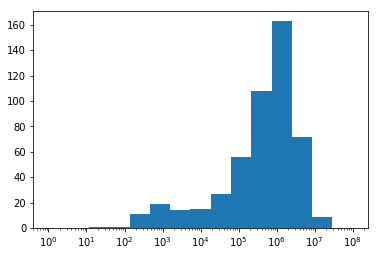

cluster 35


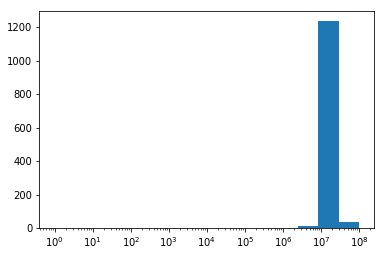

cluster 36


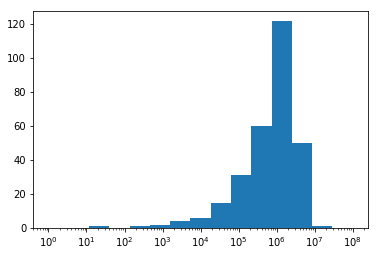

cluster 37


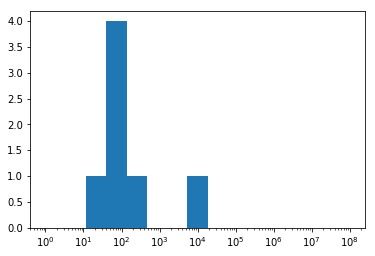

cluster 38


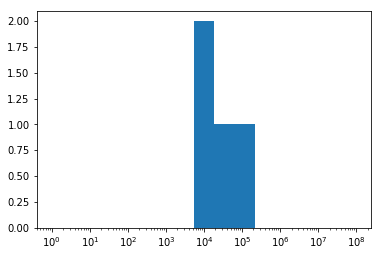

cluster 39


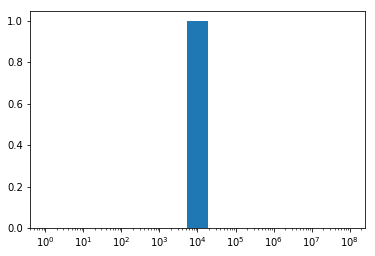

In [31]:


for clust in range(cl.n_clusters):
    cluster_data = df[cl.labels_==clust]
    print('cluster {}'.format(clust))
    logbins = np.logspace(0,8,16)
    plt.hist(cluster_data['incoming_avg_time_btwn_txns'], bins=logbins)
    plt.xscale('log')
    plt.show()
    

In [32]:
labelresults = pipe.fit_transform(dflabel.iloc[:,3:-1])

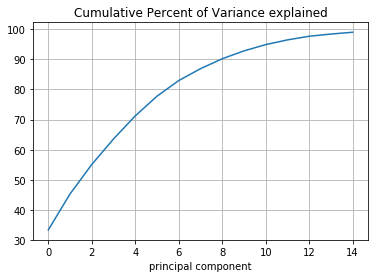

In [33]:
pca = pipe.named_steps['PCA']
plt.plot(np.arange(pca.n_components_) ,np.cumsum(pca.explained_variance_ratio_)*100)
plt.grid(b=True)
plt.xlabel('principal component')
plt.title('Cumulative Percent of Variance explained')
plt.show()

In [34]:
#scoring metric?
clusters = [2,3,4,5,6,7,8,9,10,12,15,18,20,30,40]
scores = []
inertias = []
for c in clusters:
    cl_n = KMeans(c).fit(labelresults)
    score = ch_score(labelresults, cl_n.labels_)
    scores.append(score)
    inertias.append(cl_n.inertia_)


plt.plot(clusters, scores)
plt.title('Calinski Harabaz Scores')

NameError: name 'ch_score' is not defined

In [35]:
cl = KMeans(15).fit(labelresults)
dflabel['cluster'] = [cl.labels_[i] for i in range(len(dflabel))]

In [36]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=20000)
tsne_results = tsne.fit_transform(labelresults)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.000s...
[t-SNE] Computed neighbors for 182 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 0.662880
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.883049
[t-SNE] Error after 2300 iterations: 0.315654
t-SNE done! Time elapsed: 4.287806272506714 seconds


Text(0,0.5,'second principcal component')

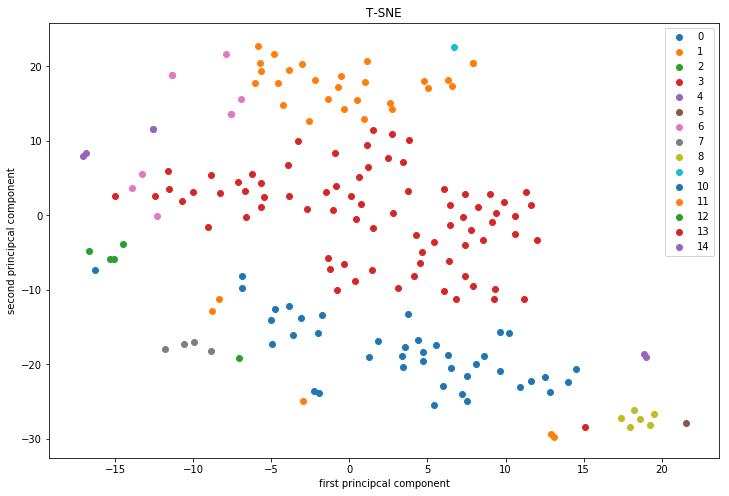

In [37]:
plt.figure(figsize=(12,8))
for c in np.unique(cl.labels_):
    mask = cl.labels_==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principcal component')
plt.ylabel('second principcal component')

Text(0,0.5,'second principal component')

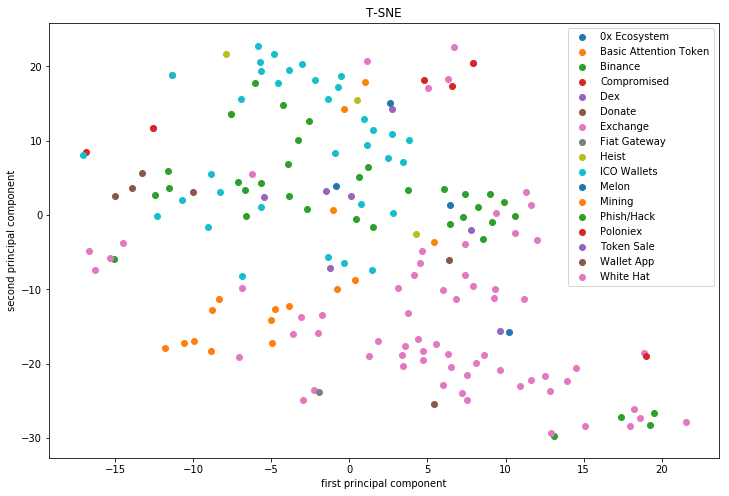

In [39]:
plt.figure(figsize=(12,8))
for c in np.unique(dflabel['category']):
    mask = dflabel['category']==c
    if np.sum(mask) <1:
        lbl = '_nolegend_'
    else:
        lbl = c
    plt.scatter(tsne_results[mask][:,0], tsne_results[mask][:,1], alpha=1,label=lbl)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.title('T-SNE')
plt.xlabel('first principal component')
plt.ylabel('second principal component')

In [ ]:
for clust in range(cl.n_clusters):
    print('cluster {}'.format(clust))
    print('labelled points: {}'.format(np.sum([dflabel['cluster']==clust])))
    print('total points: {}'.format(np.sum(cl.labels_==clust)))
    print(dflabel[dflabel['cluster']==clust][['label', 'category']])
    print('\n\n\n')